*all librosa code and feature explanation from the [CCRMA Music Information Retrieval summer intensive github repo](https://github.com/bmcfee/stanford-mir)*

In [299]:
%matplotlib inline
import numpy, scipy, matplotlib.pyplot as plt, IPython.display as ipd
import librosa, librosa.display
import seaborn as sns
import sklearn
import pandas as pd
plt.rcParams['figure.figsize'] = (14, 5)

In [300]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [301]:
sns.set_style('whitegrid')

# load audio

load the audio from the "forest" video:

In [302]:
sns.set_style('whitegrid')

In [303]:
x, sr = librosa.load('../../audioFiles/forest.wav')

In [ ]:
ipd.Audio(x, rate=sr)

# define helper functions to normalize

In [304]:
# normalize data between 0 and 1 for visualization
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

In [305]:
# normalize data to mean of 0 and unit variance

# extract root mean square energy

In [306]:
hop_length = 512
frame_length = 1024

In [307]:
energy = numpy.array([
    sum(abs(x[i:i+frame_length]**2))
    for i in range(0, len(x), hop_length)
])

In [308]:
energy.shape

(7383,)

In [309]:
rms = librosa.feature.rms(x, frame_length=frame_length, hop_length=hop_length)[0]

In [310]:
rms.shape

(7383,)

In [311]:
frames = range(len(energy))
t = librosa.frames_to_time(frames, sr=sr, hop_length=hop_length)

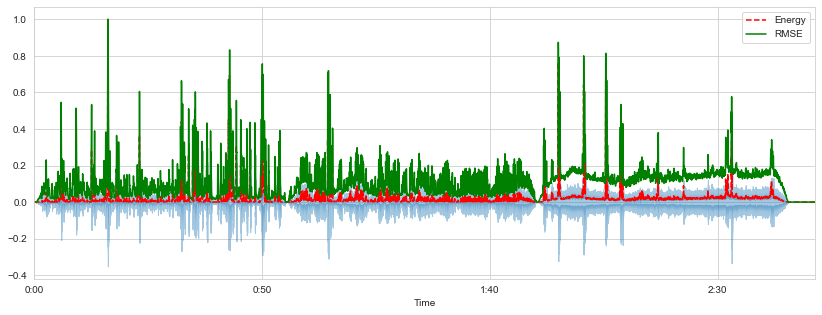

In [312]:
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, energy/energy.max(), 'r--')             # normalized for visualization
plt.plot(t[:len(rms)], rms/rms.max(), color='g') # normalized for visualization
plt.legend(('Energy', 'RMSE'))
plt.show()

In [313]:
rms = sklearn.preprocessing.scale(rms)

In [314]:
rms.mean()

-8.266986e-09

In [315]:
rms.var()

0.99999994

# extract zero line crossing rate

Add a small constant to avoid oscillation around silence triggering high zero-crossing rate:

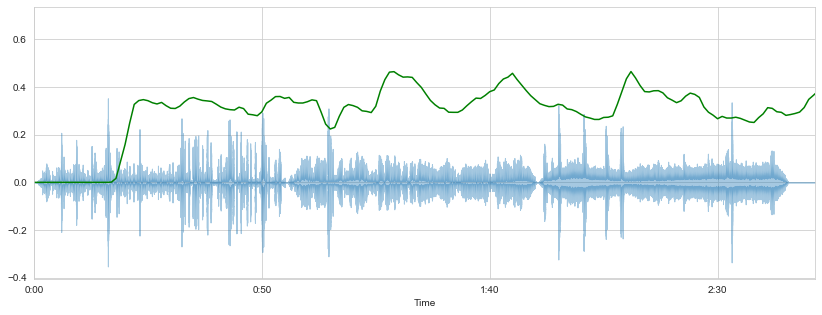

In [316]:
librosa.display.waveplot(x, sr=sr, alpha=0.4)
zcrs = librosa.feature.zero_crossing_rate(x + 0.0001)
plt.plot(zcrs[0], 'g')
plt.show()

In [317]:
zcrs.shape

(1, 7383)

# extract spectral features

### extract spectral centroid

The **spectral centroid** ([Wikipedia](https://en.wikipedia.org/wiki/Spectral_centroid)) indicates at which frequency the energy of a spectrum is centered upon. This is like a weighted mean:

$$ f_c = \frac{\sum_k S(k) f(k)}{\sum_k S(k)} $$

where $S(k)$ is the spectral magnitude at frequency bin $k$, $f(k)$ is the frequency at bin $k$.

[`librosa.feature.spectral_centroid`](https://librosa.github.io/librosa/generated/librosa.feature.spectral_centroid.html#librosa.feature.spectral_centroid) computes the spectral centroid for each frame in a signal:

In [318]:
# calculate time variable for plotting
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

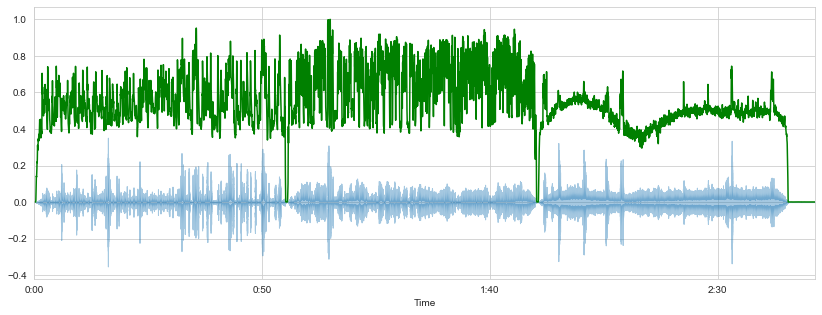

In [319]:
spectral_centroids = librosa.feature.spectral_centroid(x+0.01, sr=sr)[0] # add constant to correct value at silence
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='g') # normalize for visualization purposes
plt.show()

In [320]:
spectral_centroids = sklearn.preprocessing.scale(spectral_centroids)

In [321]:
spectral_centroids.mean()

6.159384408593582e-17

In [322]:
spectral_centroids.var()

1.0000000000000002

### extract spectral bandwidth

[`librosa.feature.spectral_bandwidth`](https://librosa.github.io/librosa/generated/librosa.feature.spectral_bandwidth.html#librosa.feature.spectral_bandwidth) computes the order-$p$ spectral bandwidth:

$$ \left( \sum_k S(k) \left(f(k) - f_c \right)^p \right)^{\frac{1}{p}} $$

where $S(k)$ is the spectral magnitude at frequency bin $k$, $f(k)$ is the frequency at bin $k$, and $f_c$ is the spectral centroid. When $p = 2$, this is like a weighted standard deviation.

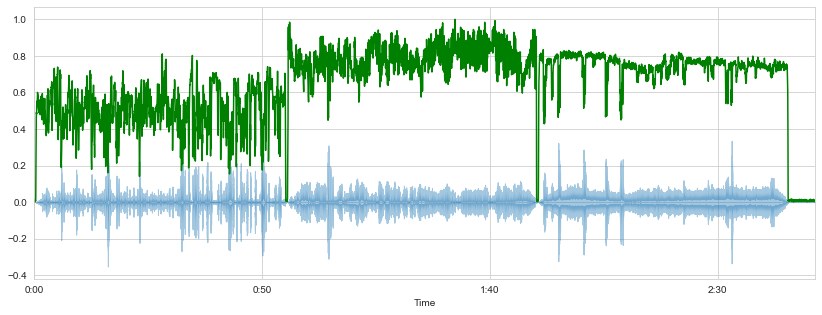

In [323]:
spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr)[0]
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_bandwidth_2), color='g')
plt.show()

In [324]:
spectral_bandwidth_2 = sklearn.preprocessing.scale(spectral_bandwidth_2)

In [325]:
spectral_bandwidth_2.mean()

-1.5398461021483954e-16

In [326]:
spectral_bandwidth_2.var()

1.0000000000000002

### extract spectral rolloff

**Spectral rolloff** is the frequency below which a specified percentage of the total spectral energy, e.g. 85%, lies.

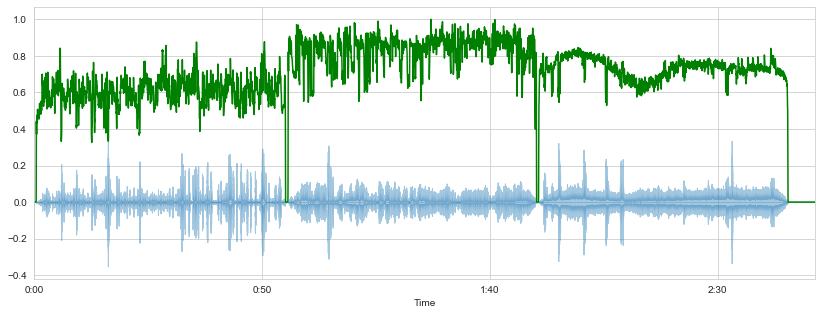

In [327]:
spectral_rolloff = librosa.feature.spectral_rolloff(x+0.01, sr=sr)[0]
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='g')
plt.show()

In [328]:
spectral_rolloff = sklearn.preprocessing.scale(spectral_rolloff)

In [329]:
spectral_rolloff.mean()

1.3858614919335558e-16

In [330]:
spectral_rolloff.var()

0.9999999999999997

### extract spectral novelty

We will compute a **spectral novelty function** ([FMP](https://www.audiolabs-erlangen.de/resources/MIR/FMP/C0/C0.html), p. 309):

1.  Compute the log-amplitude spectrogram.
2.  Within each frequency bin, $k$, compute the energy novelty function as shown earlier, i.e. (a) first-order difference, and (b) half-wave rectification.
3.  Sum across all frequency bins, $k$.

In [331]:
spectral_novelty = librosa.onset.onset_strength(x, sr=sr)

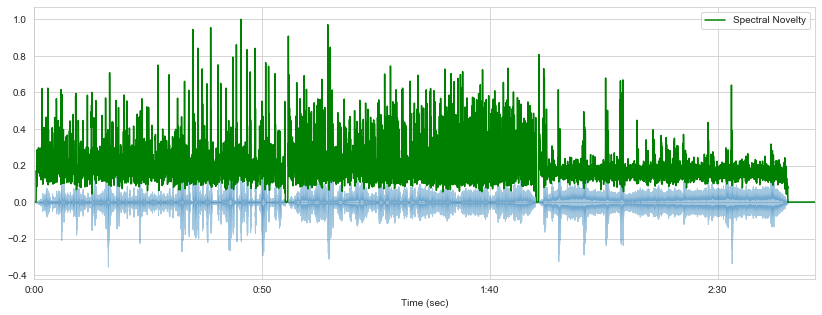

In [332]:
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_novelty), 'g')
plt.xlim(0, t.max())
plt.xlabel('Time (sec)')
plt.legend(('Spectral Novelty',))
plt.show()

In [333]:
spectral_novelty = sklearn.preprocessing.scale(spectral_novelty)

/Users/trqk-data/.local/share/virtualenvs/nature-nurtures--FcyQ97q/lib/python3.7/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [334]:
spectral_novelty.mean()

0.0

In [335]:
spectral_novelty.var()

1.0000001

### Extract Mel Frequency Cepstral Coefficients (MFCCs)

MFCCs 

In [336]:
mfccs = librosa.feature.mfcc(x, sr=sr)
print(mfccs.shape)

(20, 7383)


display MFCCs:

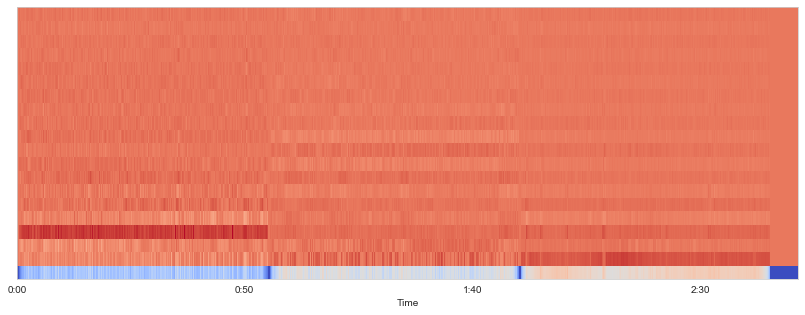

In [337]:
librosa.display.specshow(mfccs, sr=sr, x_axis='time')
plt.show()

Let's scale the MFCCs such that each coefficient dimension has zero mean and unit variance:

In [338]:
mfccs = sklearn.preprocessing.scale(mfccs, axis=1)
print(mfccs.mean(axis=1))
print(mfccs.var(axis=1))

[ 2.4478028e-08 -1.7526979e-08 -3.9790925e-07 -1.9843995e-07
 -1.8713743e-08 -4.1657859e-09 -1.2973678e-08 -2.5059300e-08
  2.6544775e-08 -3.5457617e-08  2.5083521e-08  3.5360741e-09
  3.8117747e-08 -4.5484569e-08  5.3156153e-08  2.2451648e-08
 -3.4957583e-08 -3.3407019e-08 -1.0148048e-08  5.8999152e-08]
[0.99999684 0.9999978  1.0000142  0.9999928  1.0000222  1.0000057
 1.0000012  1.0000045  0.99999297 0.999995   0.9999906  1.0000012
 1.0000141  0.9999916  0.9999927  1.0000049  0.99999785 1.0000064
 0.99999017 1.0000147 ]


/Users/trqk-data/.local/share/virtualenvs/nature-nurtures--FcyQ97q/lib/python3.7/site-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/Users/trqk-data/.local/share/virtualenvs/nature-nurtures--FcyQ97q/lib/python3.7/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


Display all the scaled MFCCs:

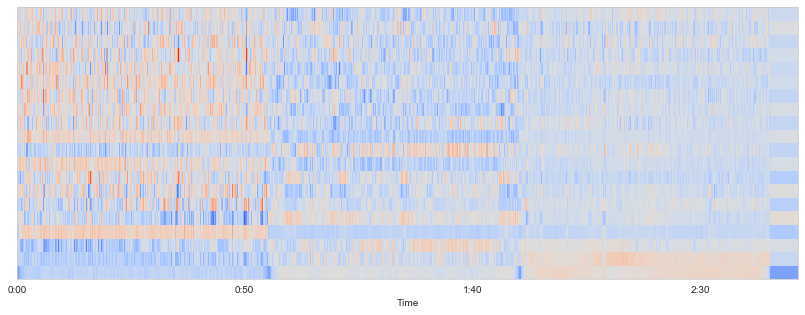

In [339]:
librosa.display.specshow(mfccs, sr=sr, x_axis='time')
plt.show()

Pull out one MFCC:

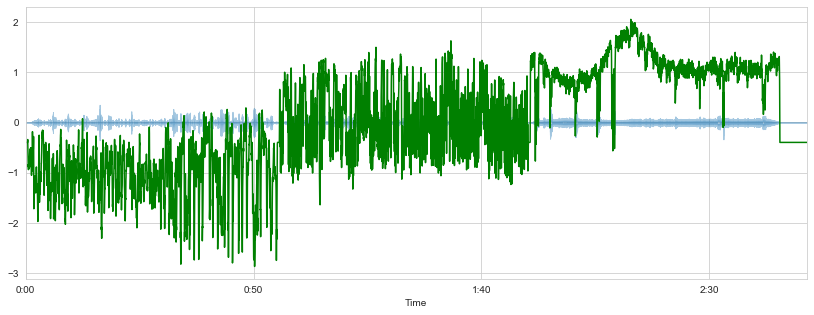

In [340]:
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, mfccs[1], color='g')
plt.show()

# Create Feature Vector

Append spectral features to MFCCs as new rows of the array:

In [341]:
def add_second_dimension_to_array(the_array):
    cols = the_array.shape[0]
    return numpy.reshape(the_array, (-1, 7383))

In [342]:
mfccs.shape

(20, 7383)

In [373]:
spectral_features = [
rms,
spectral_centroids,
spectral_bandwidth_2,
spectral_rolloff,
spectral_novelty,
]

In [374]:
X = mfccs
for feature in spectral_features:
    X = numpy.append(X, add_second_dimension_to_array(feature), axis=0)

In [375]:
X.shape

(25, 7383)

features 0-19 are MFCCs, after which:
* index 20: RMS
* index 21: spectral centroid
* index 22: spectral bandwidth
* index 23: spectral rolloff
* index 24: spectral novelty

# Apply Principal Component Analysis to See Which Features Predict the Signal Most

In [376]:
X.mean()

-4.1640593931537445e-09

In [377]:
model = sklearn.decomposition.PCA(n_components=2, whiten=True)

In [378]:
model.fit(X.T)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=True)

In [379]:
Y = model.transform(X.T)

In [380]:
print(Y.shape)

(7383, 2)


In [381]:
model.components_.shape

(2, 25)

In [382]:
component_magnitudes = pd.DataFrame(model.components_, index = ['PC-1','PC-2'])
component_magnitudes = abs(component_magnitudes)

In [383]:
component_magnitudes.iloc[0].sort_values(ascending=False)

10    0.324636
3     0.310507
8     0.305975
22    0.298448
23    0.277885
2     0.266958
0     0.265849
9     0.255736
12    0.220609
14    0.206383
1     0.204185
15    0.190076
13    0.173943
21    0.168817
4     0.156559
19    0.153950
17    0.121177
16    0.110883
6     0.109418
20    0.068276
11    0.065134
18    0.056558
24    0.053846
7     0.030598
5     0.001483
Name: PC-1, dtype: float64

In [384]:

component_magnitudes.iloc[1].sort_values(ascending=False)

21    0.436994
24    0.336268
5     0.318411
4     0.301756
20    0.301418
23    0.290287
1     0.277378
7     0.256386
3     0.243528
0     0.176267
6     0.170599
14    0.161189
12    0.105342
16    0.082757
11    0.073791
22    0.063919
10    0.059751
15    0.058309
9     0.044726
19    0.044056
2     0.035789
13    0.018132
17    0.013713
18    0.008034
8     0.003827
Name: PC-2, dtype: float64

For the forest biome's audio:

Component 1 depends substantially on MFCCs 11, 4, and 9, with lesser but significant contributions made by spectral bandwidth and spectral rolloff. 

Component 2 depends largely on RMS energy, spectral centroid, rolloff, and novelty, as well as MFCCs 5 and 6.

# Signal Decomposition via Non-Negative Matrix Factorization

In [353]:
S = librosa.stft(x)
print(S.shape)

(1025, 7383)


/Users/trqk-data/.local/share/virtualenvs/nature-nurtures--FcyQ97q/lib/python3.7/site-packages/librosa/core/spectrum.py:1700: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


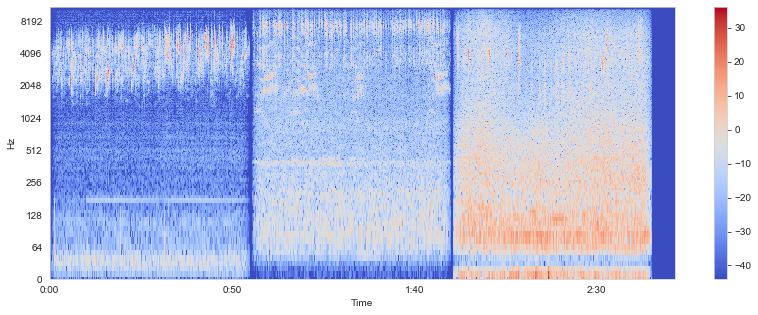

In [354]:
Smag = librosa.amplitude_to_db(S)
librosa.display.specshow(Smag, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()
plt.show()

In [355]:
X = numpy.absolute(S)
n_components = 6
W, H = librosa.decompose.decompose(X, n_components=n_components, sort=True)
print(W.shape)
print(H.shape)

(1025, 6)
(6, 7383)


Plot each spectral component:

/Users/trqk-data/.local/share/virtualenvs/nature-nurtures--FcyQ97q/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


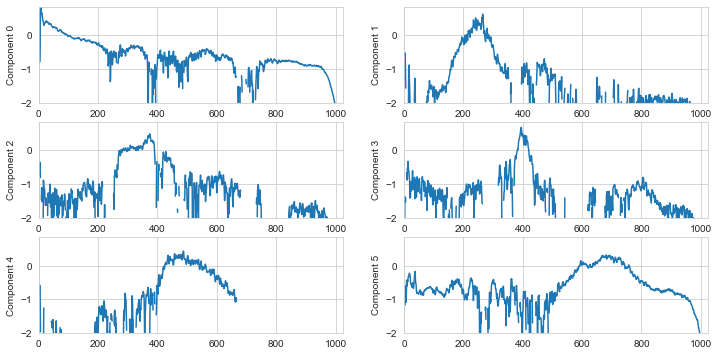

In [356]:
plt.figure(figsize=(12, 6))
logW = numpy.log10(W)
for n in range(n_components):
    plt.subplot(numpy.ceil(n_components/2.0), 2, n+1)
    plt.plot(logW[:,n])
    plt.ylim(-2, logW.max())
    plt.xlim(0, W.shape[0])
    plt.ylabel('Component %d' % n)

temporal activations of each component:

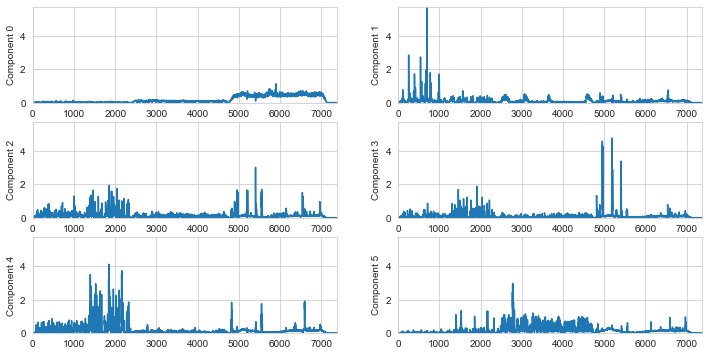

In [357]:
plt.figure(figsize=(12, 6))
for n in range(n_components):
    plt.subplot(numpy.ceil(n_components/2.0), 2, n+1)
    plt.plot(H[n])
    plt.ylim(0, H.max())
    plt.xlim(0, H.shape[1])
    plt.ylabel('Component %d' % n)

Listen to components:

In [ ]:
reconstructed_signal = scipy.zeros(len(x))
for n in range(n_components):
    Y = scipy.outer(W[:,n], H[n])*numpy.exp(1j*numpy.angle(S))
    y = librosa.istft(Y)
    reconstructed_signal[:len(y)] += y
    ipd.display( ipd.Audio(y, rate=sr) )

Reconstructed full mix:

In [ ]:
ipd.Audio(reconstructed_signal, rate=sr)

residual:

In [ ]:
residual = x - reconstructed_signal
residual[0] = 1 # hack to prevent automatic gain scaling
ipd.Audio(residual, rate=sr)